In [29]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [30]:
BATCH_SIZE = 32
IMAGE_Width = 222
IMAGE_Hight = 222
CHANNELS=3
EPOCHS=50


In [31]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "skindata",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_Width,IMAGE_Hight),
    batch_size=BATCH_SIZE
)

Found 1590 files belonging to 3 classes.


In [32]:
class_names = dataset.class_names
class_names

['Chickenpox', 'Cradle_Cap', 'Heat_Rash']

In [33]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())
    

(32, 222, 222, 3)
[2 0 2 2 2 0 0 0 0 0 0 1 2 1 1 2 2 1 2 1 0 2 1 2 2 1 1 1 2 0 1 1]


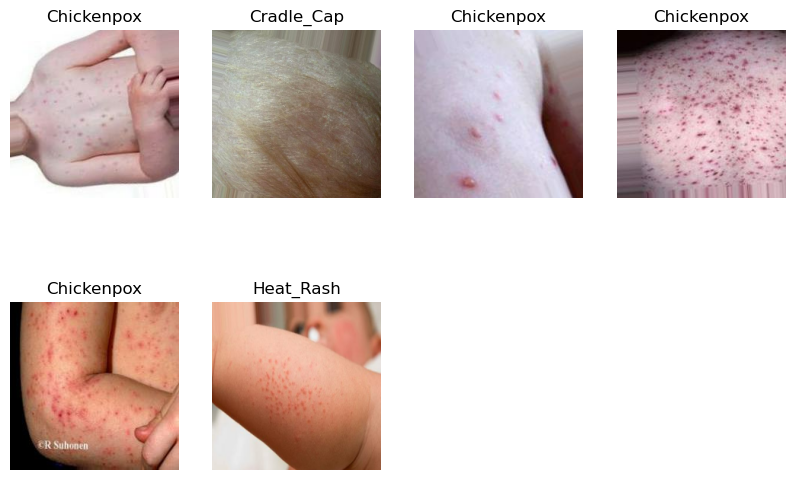

In [34]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(6):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [35]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [36]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [37]:
len(train_ds)

40

In [38]:
len(val_ds)

5

In [39]:
len(test_ds)

5

In [40]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [41]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_Width, IMAGE_Hight),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [42]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),  
])

In [43]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [44]:
input_shape = (BATCH_SIZE, IMAGE_Width, IMAGE_Hight, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.5),  # Add dropout layer
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Add dropout layer
    layers.Dense(len(class_names), activation='softmax'),
])

model.build(input_shape=input_shape)

In [45]:
initial_learning_rate = 1e-4
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=1000, decay_rate=0.96, staircase=True
)

In [46]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [47]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 222, 222, 3)         0         
                                                                 
 sequential_4 (Sequential)   (None, 222, 222, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (32, 220, 220, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (32, 110, 110, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (32, 108, 108, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (32, 54, 54, 64)          0         
 g2D)                                                 

In [48]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=60
)

Epoch 1/60
40/40 [==============================] - 73s 1s/step - loss: 1.1059 - accuracy: 0.3398 - val_loss: 1.0946 - val_accuracy: 0.3467
Epoch 2/60
40/40 [==============================] - 51s 1s/step - loss: 1.0729 - accuracy: 0.4203 - val_loss: 1.0361 - val_accuracy: 0.4133
Epoch 3/60
40/40 [==============================] - 50s 1s/step - loss: 1.0241 - accuracy: 0.4453 - val_loss: 0.9735 - val_accuracy: 0.4533
Epoch 4/60
40/40 [==============================] - 50s 1s/step - loss: 0.9699 - accuracy: 0.5125 - val_loss: 1.0698 - val_accuracy: 0.3733
Epoch 5/60
40/40 [==============================] - 50s 1s/step - loss: 0.9458 - accuracy: 0.5063 - val_loss: 0.8964 - val_accuracy: 0.5533
Epoch 6/60
40/40 [==============================] - 51s 1s/step - loss: 0.9128 - accuracy: 0.5562 - val_loss: 0.9613 - val_accuracy: 0.5133
Epoch 7/60
40/40 [==============================] - 50s 1s/step - loss: 0.8996 - accuracy: 0.5680 - val_loss: 0.8743 - val_accuracy: 0.5467
Epoch 8/60
40/40 [==

40/40 [==============================] - 48s 1s/step - loss: 0.2636 - accuracy: 0.8961 - val_loss: 0.5189 - val_accuracy: 0.8000
Epoch 60/60
40/40 [==============================] - 48s 1s/step - loss: 0.2267 - accuracy: 0.9133 - val_loss: 0.4783 - val_accuracy: 0.8333


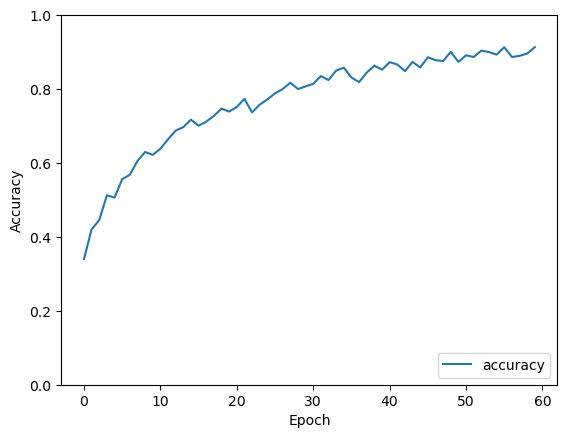

In [49]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

In [50]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_ds)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

5/5 [==============================] - 22s 214ms/step - loss: 0.5563 - accuracy: 0.8125
Test Loss: 0.5562578439712524
Test Accuracy: 0.8125


In [51]:
model.save('skin_trial22.h5')

C:\Users\mikey\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [60]:
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
import tensorflow as tf
import numpy as np

# Load the model
model = tf.keras.models.load_model('skin_trial22.h5')

# Define class names
class_names = ['chickenpox', 'cradle_cap', 'Heat_rush']  

def preprocess_image(image_path, target_size=(222, 222)):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=target_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch
    return img_array

def predict_image():
    file_path = filedialog.askopenfilename()
    if file_path:
        # Load and display the selected image
        img = Image.open(file_path)
        img.thumbnail((250, 250))  # Resize the image for display
        img = ImageTk.PhotoImage(img)
        image_label.config(image=img)
        image_label.image = img  # Keep a reference to avoid garbage collection
        
        # Preprocess the image for prediction
        img_array = preprocess_image(file_path)
        
        # Make predictions
        predictions = model.predict(img_array)
        predicted_class = class_names[np.argmax(predictions)]
        
        # Update the result label
        result_label.config(text=f"Predicted Class: {predicted_class}")

# Create Tkinter window
root = tk.Tk()
root.title("Skin Image Classifier")

# Create GUI components
browse_button = tk.Button(root, text="Browse", command=predict_image)
browse_button.pack(pady=10)

image_label = tk.Label(root)
image_label.pack(pady=10)

result_label = tk.Label(root, text="")
result_label.pack(pady=10)

# Run the Tkinter event loop
root.mainloop()


In [53]:
from sklearn.metrics import f1_score

# Make predictions on the test dataset
y_true = []  # true labels
y_pred = []  # predicted labels

for images, labels in test_ds:
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(predicted_classes)

# Calculate F1 score for each class
f1_scores = f1_score(y_true, y_pred, average=None)

# Print F1 scores for each class
for i, score in enumerate(f1_scores):
    print(f"F1 Score for Class {i}: {score}")


1/1 [==============================] - 1s 540ms/step
F1 Score for Class 0: 0.8571428571428571
F1 Score for Class 1: 0.9137931034482758
F1 Score for Class 2: 0.7058823529411764


In [54]:
from sklearn.metrics import precision_score

# Calculate precision for each class
precision_scores = precision_score(y_true, y_pred, average=None)

# Print precision for each class
for i, score in enumerate(precision_scores):
    print(f"Precision for Class {i}: {score}")

Precision for Class 0: 0.8225806451612904
Precision for Class 1: 0.8412698412698413
Precision for Class 2: 0.8571428571428571


In [55]:
from sklearn.metrics import recall_score

# Calculate recall for each class
recall_scores = recall_score(y_true, y_pred, average=None)

# Print recall for each class
for i, score in enumerate(recall_scores):
    print(f"Recall for Class {i}: {score}")

Recall for Class 0: 0.8947368421052632
Recall for Class 1: 1.0
Recall for Class 2: 0.6
